In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import sklearn

import torch
from torch import nn

import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
good_columns = ['LotFrontage',
                'LotArea',
                'OverallQual',
                'YearBuilt',
                'YearRemodAdd',
                'MasVnrArea',
                'BsmtFinSF1',
                'BsmtUnfSF',
                'TotalBsmtSF',
                '1stFlrSF',
                '2ndFlrSF',
                'GrLivArea',
                'BsmtFullBath',
                'FullBath',
                'HalfBath',
                'BedroomAbvGr',
                'KitchenAbvGr',
                'TotRmsAbvGrd',
                'Fireplaces',
                'GarageYrBlt',
                'GarageCars',
                'GarageArea',
                'WoodDeckSF',
                'OpenPorchSF',
                'EnclosedPorch',
                'SalePrice']

In [5]:
numeric_columns = []
numeric_columns.extend(list(data.dtypes[data.dtypes == np.int64].index))
numeric_columns.extend(list(data.dtypes[data.dtypes == np.float64].index))

In [6]:
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

good_numeric = list(set(good_columns) & set(numeric_columns))

numeric_data = DataFrame(data, columns=good_numeric)

In [7]:
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)

for col in nan_columns:
    numeric_data[col] = numeric_data[col].fillna(np.nan)

In [8]:
numeric_x_columns = list(numeric_data.columns)
numeric_x_columns.remove('SalePrice')
numeric_y_columns = ['SalePrice']

non_numeric_columns = [col for col in data.columns if col not in good_numeric]

non_numeric_data = pd.get_dummies(data[non_numeric_columns])

In [9]:
X_num = DataFrame(numeric_data, columns=numeric_x_columns)
X_non_num = DataFrame(non_numeric_data)

target = DataFrame(numeric_data, columns=numeric_y_columns)

full_data = pd.concat([X_num, X_non_num], axis = 1)

full_data.drop(columns=['Id'], inplace=True)

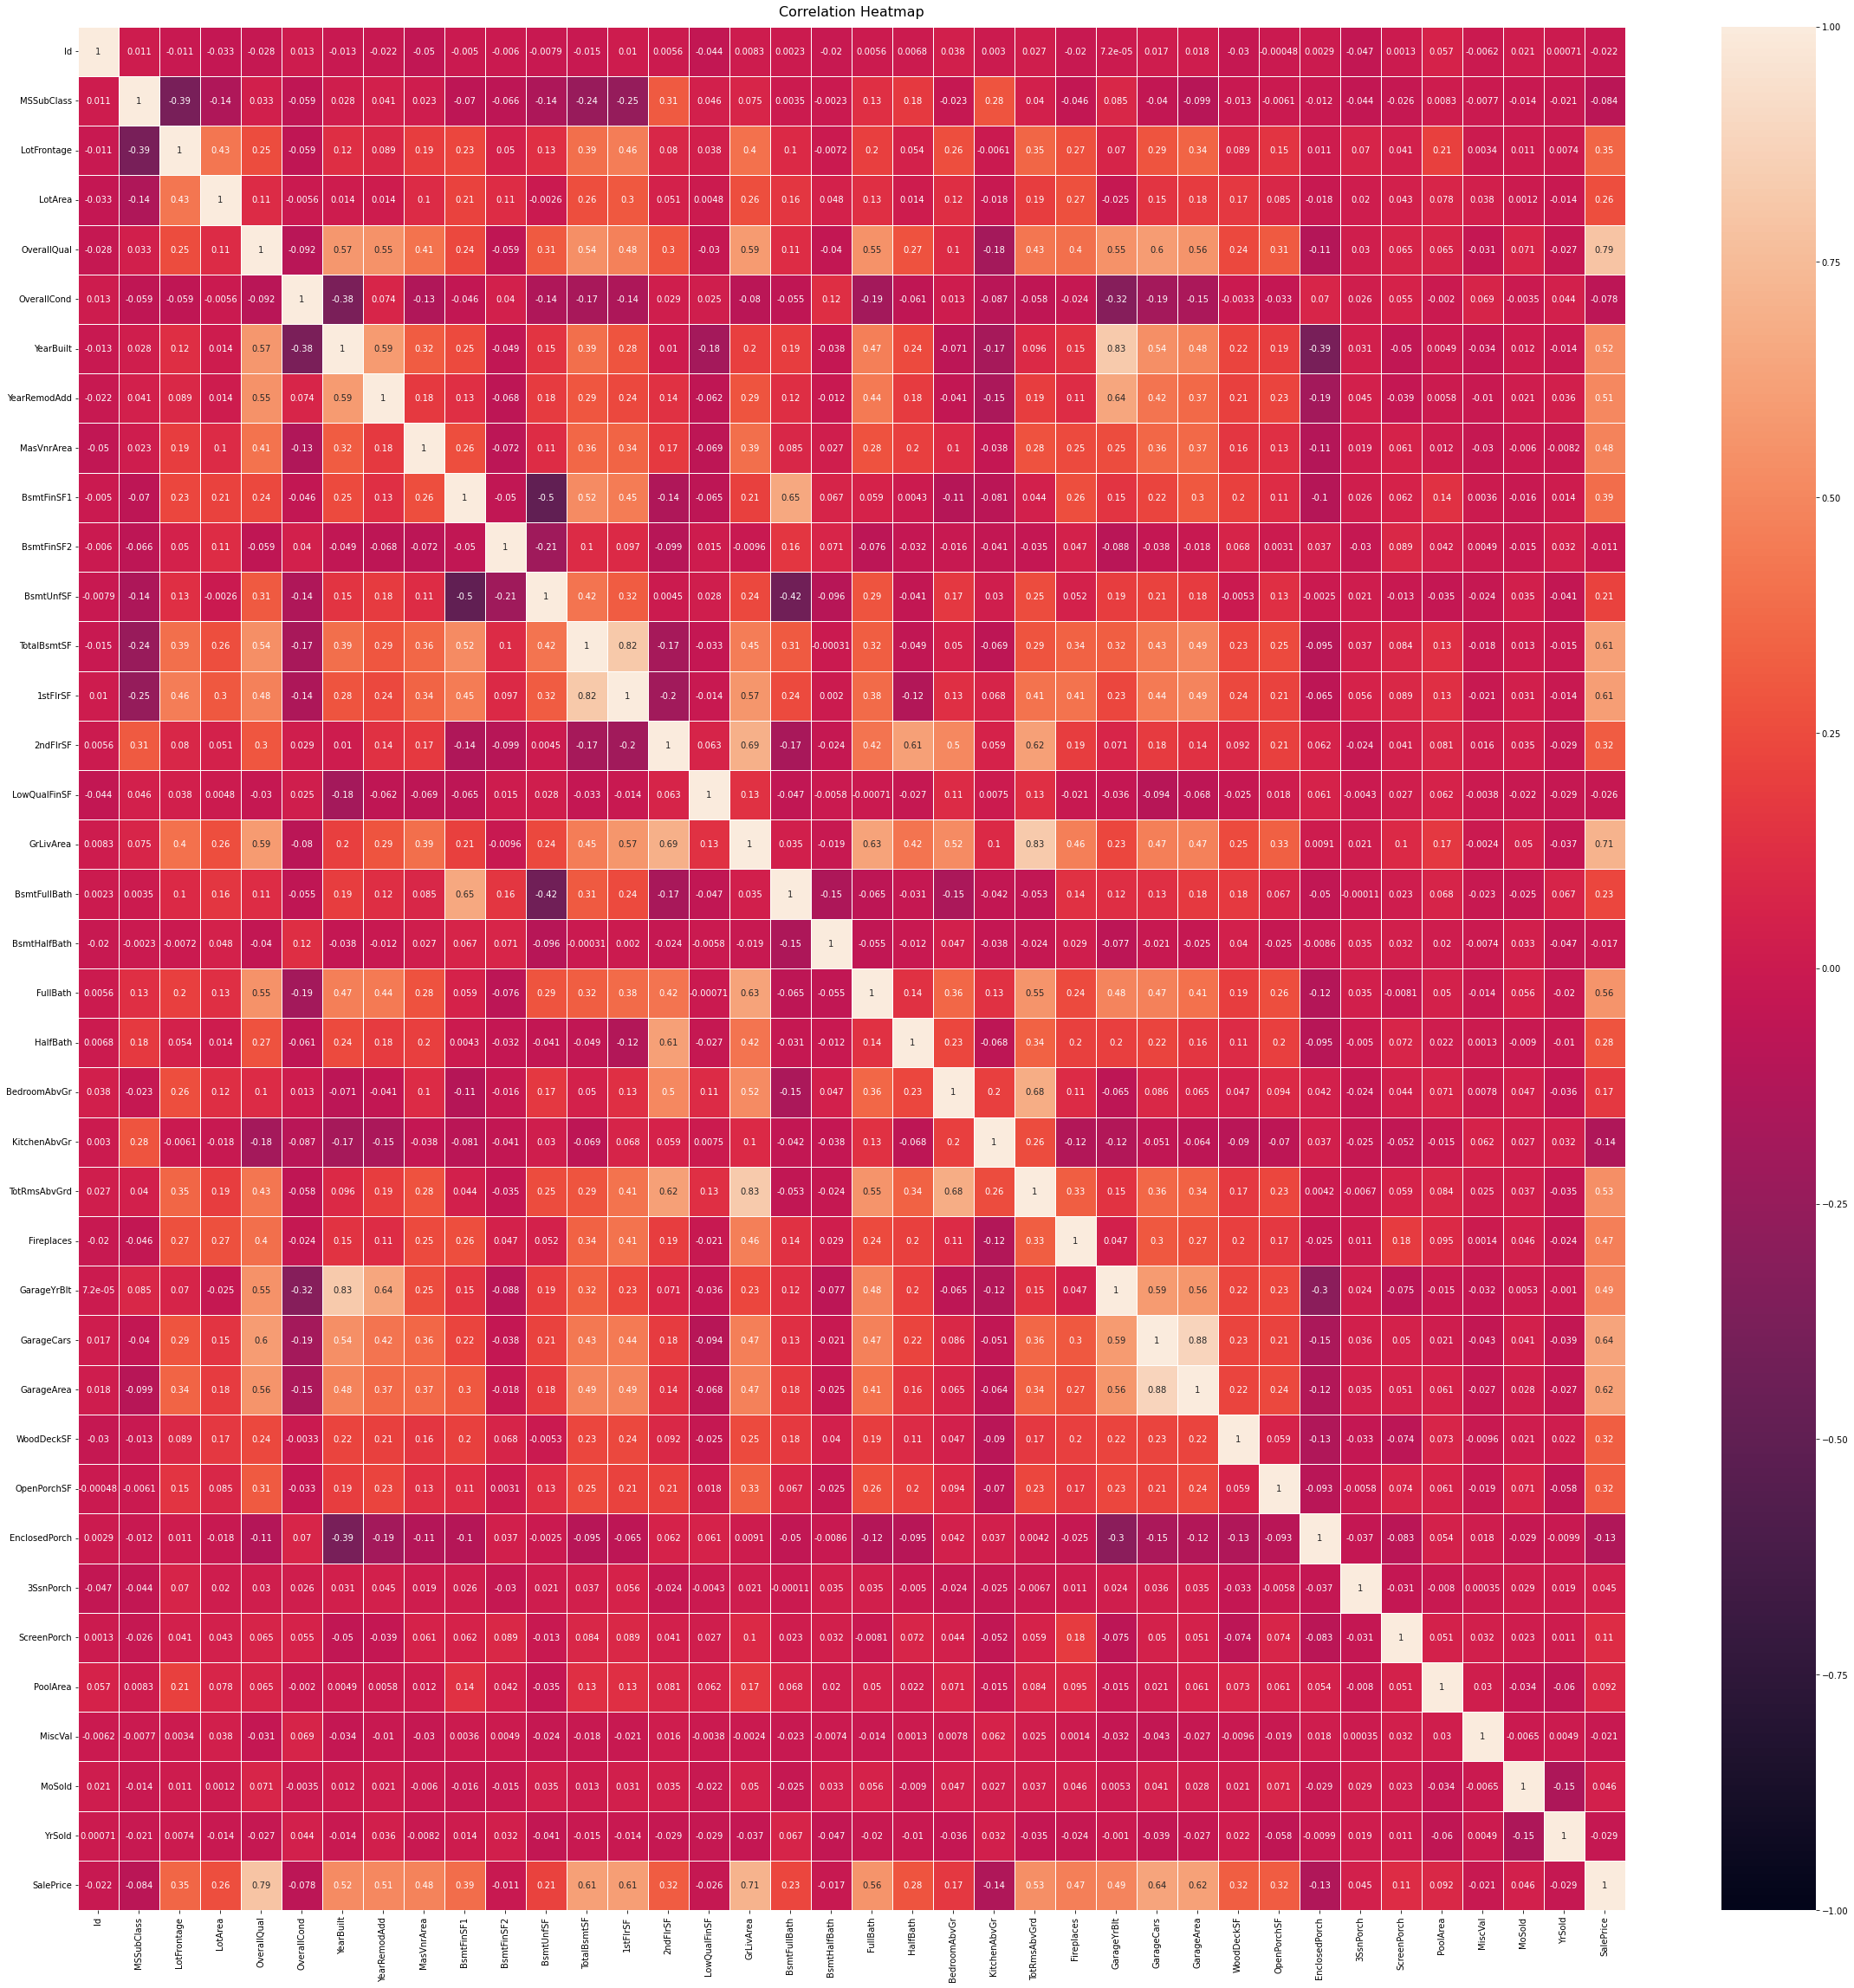

In [10]:
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(40,40))

# heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, ax=ax)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

# plt.savefig("plot.pdf")

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
full_data = imp.fit_transform(full_data)

X_train, X_test, y_train, y_test = train_test_split(full_data, target, train_size=0.8)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DEVICE = 'cuda:0'

X_train_t = torch.tensor(X_train, dtype=torch.float).to(DEVICE)
y_train_t = torch.tensor(y_train.values, dtype=torch.float).to(DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float).to(DEVICE)
y_test_t = torch.tensor(y_test.values, dtype=torch.float).to(DEVICE)

In [ ]:
net = torch.nn.Sequential(
        nn.Linear(full_data.shape[1], 200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200, 100),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Dropout(p=0.3),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Dropout(p=0.3),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 1),
)

net.to(DEVICE)

In [ ]:
from tqdm.notebook import trange

train_losses = []
val_losses = []

epochs = 5
n_iters = 500

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)


for epoch in trange(epochs):
    for t in trange(n_iters):
        y_pred = net(X_train_t)

        loss = criterion(y_pred, y_train_t)
        train_losses.append(loss.item() ** 0.5)

        with torch.no_grad():
            y_pred_test = net(X_test_t)
            loss_eval = criterion(y_pred_test, y_test_t)
            val_losses.append(loss_eval.item() ** 0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})

sns.set_style("dark")

sns.lineplot(x=range(len(train_losses)), y=train_losses, label='train')
sns.lineplot(x=range(len(val_losses)), y=val_losses, label='val')

In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(net(X_test_t).cpu().detach().numpy(), y_test_t.cpu().numpy(), squared=False))